In [1]:
%load_ext Cython
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [237]:
%%cython
cimport cython

import numpy as np
cimport numpy as np
import networkx as nx
from scipy.linalg import toeplitz

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_J(int states):
    '''
    Interaction matrix initialization
    Options:
    - 1: Standard Q-Potts model J matrix
    - 2: Non-directional Value Chain encoding
    - 3: Directional Value Chain encoding 
    '''
    assert states > 1, 'number of states needs to be more than 1'
    cdef np.ndarray J 
    
    cdef int option = 2
    
    if option == 1:
        J = np.identity((states))
        if states == 2:
            J = np.array([[0, 1],\
                          [1, 0]])
        
    if option == 2:
        if states == 2: # A <-> A , B <-> B
            J = np.array([[0, 1],\
                          [1, 0]])
        else:
            first_row = np.zeros(states)
            first_row[1] = 1
            first_col = np.zeros(states)
            first_col[1] = 1

            J = toeplitz(first_col, first_row)

    if option == 3:
        first_row = np.zeros(states)
        first_row[1] = 1
        first_col = np.zeros(states)
        first_col[1] = 0

        J = toeplitz(first_col, first_row)
    return J

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray J):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
#         if cur_node == cur_nb:
#             kronecker = 1
#         H += -1 * (1 - kronecker) #J[cur_node, cur_nb]) # * V[]
        H -= J[cur_node, cur_nb]
    return H
    
cdef metropolis(G, A, J, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (=new state) - H1 (=old state)) .
    System hamiltonian and magnetization is changed.
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list fm = []

    fm.append(G.mean())
    cdef list history_arr = []
    
    for t in range(time):    
        for i in range(len(G)):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, J)
                        
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, J)
            
            # calculate energy difference
            dE = (H2 - H1)
                        
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state
                system_hamiltonian += dE
                
            # change configuration back to the original
            else: 
                G[rand_node] = spin
    
            sh.append(system_hamiltonian)
            fm.append(G.mean())
            history_arr.append(G.copy())

    return G, sh, history_arr

### Analysis functions
cdef float full_hamiltonian(G, A, J):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, J)
    return 0.5 * system_hamiltonian

### Satisfaction functions
cdef float full_satisfaction(G,A,J):
    'returns average satisfaction of the nodes'
    cdef float system_satisfaction = 0
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_satisfaction += local_satisfaction(G, G[i], nb, J)
    return system_satisfaction * 0.5

cdef float local_satisfaction(G, int node, np.ndarray nb, np.ndarray J):
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int s = 0
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        if J[cur_node, cur_nb] == 0:
            s -=0
        else: 
            s += 1  
    return s

### Find value chain functions

cdef chains(G, A, J):
    '''
    This functions returns the number of full value chains present in the network.
    '''
    cdef np.ndarray nb
    # determine VC length
    cdef int VC_length = J.shape[0]
    cdef np.ndarray chains_of_length = np.zeros((VC_length))
    cdef np.ndarray nodes_in_state = np.zeros((VC_length))
    
    # find starting points of VC e.g. where state == 0
    cdef start_nodes = np.where(G==0)[0]
    cdef list nodes_in_chain = []
    
    nodes_in_chain.append(start_nodes)
    chains_of_length[0] = len(start_nodes)
  
    for state in range(VC_length):
        c = []
        for node in nodes_in_chain[state]:
#             print("node", node)
            nb = neighbors(A, node)
            for i in range(len(nb)):
            # TODO change to J matrix
                if G[nb[i]] == (state + 1):
#                     print(nb[i])
                    c.append(nb[i])
                    chains_of_length[state+1] = len(c)
        nodes_in_chain.append(c)
    return chains_of_length

cdef local_chain_satisfactions(G, A, J):
    cdef np.ndarray nb
    cdef satisfaction = 0
    cdef G_satisfaction = []
    cdef int node_i = 0
    cdef int state_node = 0 

    for node_i, state_node in enumerate(G):
        satisfaction = 0
        nb = neighbors(A, node_i)
        for i in range(len(nb)):
            if J[int(state_node), int(G[nb[i]])] == 1:
                satisfaction += 1
            else:
                satisfaction -= 1
                
        G_satisfaction.append(satisfaction)
    return G_satisfaction

### Simulation functions
def simulate(T, states):
    lattice_size = 10
    G, A = initialize_lattice(lattice_size, states)
    G_init = G.copy()
    J = init_J(states) 
    sh = full_hamiltonian(G,A,J)        
    beta = 1 / T
    timesteps = 100
    M, system_hamiltonian, fm = metropolis(G, A, J, states, beta, timesteps, sh)
    return G_init, J, system_hamiltonian, A, fm

def check(G, A, J):
    c = chains(G, A, J)
    return c

def check_local(G, A, J):
    G_satisfaction = local_chain_satisfactions(G, A, J)
#     print(np.array(G_satisfaction).reshape(10,10))
    return np.mean(G_satisfaction)

def sep_ham(fm, A, J):
    l = []
    for step in range(len(fm)+1):
        l.append(full_hamiltonian(fm[step], A, J))
    return l
    
def sep_sat(fm, A, J):
    l= []
    for step in range(len(fm)):
        l.append(full_satisfaction(fm[step], A, J))
    return l

In [232]:
G_init, J, system_hamiltonian, A, fm = simulate(55, 2)
print(fm[-1].reshape(10,10))
# plt.imshow(fm[0].reshape(10,10))
# plt.plot(np.arange(0, len(system_hamiltonian)), system_hamiltonian)
print(check_local(fm[-1], A, J))

[[1 1 1 0 0 1 1 1 1 0]
 [0 1 0 1 1 1 1 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 1 0]
 [1 0 0 1 0 0 1 1 0 1]
 [0 1 1 0 1 1 0 0 1 0]
 [0 1 0 1 0 1 0 0 0 0]
 [0 1 0 1 0 0 1 1 0 1]
 [0 1 0 0 0 0 1 0 1 0]
 [1 1 0 1 0 0 0 1 0 1]]
[[ 0 -3  1  1  1 -1 -3 -1  1  0]
 [ 3  2  2  0  0 -2  0  0 -2 -3]
 [ 3  0 -2  0  2 -2  0 -2 -2 -3]
 [ 1 -4 -2 -2  2  0  0 -2  2  1]
 [ 3  0  0  2  2  0  0  0  4  3]
 [ 1  0  2  4  2  0  0  0  4  1]
 [-1  0  2  2  2  2  0 -2 -2 -1]
 [-1  0  0  2 -2  0  0  2  2  3]
 [ 1  0 -2  0 -4 -2  2  4  4  3]
 [ 0 -1  1  3 -1 -3  1  3  3  2]]
0.36


In [ ]:
def put_in_dataframe(fm, system_hamiltonian, A, J):
    '''
    Save data in convenient manner using pandas dataframe for each run, which is stored in a dictionary.
    '''
    df = pd.DataFrame(data=fm)
    # put energy value of timestep in last column
#     df.loc[:, fm[0].shape[0]+1] = sep_ham(fm, A, J)
    df.loc[:, fm[0].shape[0]+2] = system_hamiltonian
    df.loc[:, fm[0].shape[0]+3] = sep_sat(fm, A, J)
    return df

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


In [7]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)

def perform_tests(temperatures, states, samples):
    '''
    Perform multiple simulations with different temperatures and states.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    l = len(temperatures) * len(states) * len(samples)
    i = 0
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 100)
    
    runs = {}
    for state in states:
        for temp in temperatures:
            for run in samples:
                G_init, J, system_hamiltonian, A, fm = simulate(temp, state)
                df = put_in_dataframe(fm, system_hamiltonian, A, J)
                runs[f'run{state,temp,run}'] = df
                    
                printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 100)
                i += 1
    return runs

runs = perform_tests(temperatures, states, samples)

Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


### dump

In [8]:
# filename = 'experiment1-standard-potts'
# outfile = open(filename,'wb')
# pickle.dump(runs,outfile)
# outfile.close()

### open

In [51]:
filename = 'experiment1-nondirectional'
infile = open(filename,'rb')
runs = pickle.load(infile)
infile.close()

### Phase transition
Change of final hamiltonian for different temperatures. 
Average of multiple samples for multiple states

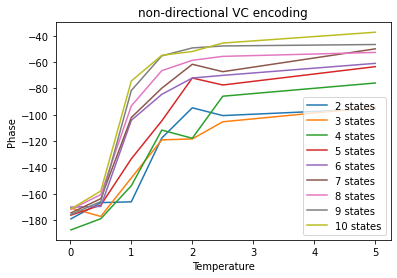

In [113]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)

lattice_size = 10
timesteps = 100
i1 = lattice_size**2 + 1
i2 = lattice_size**2 * timesteps - 1

for state in states:
        l = []
        k = []
        for temp in temperatures:
            fh = 0
            sh = 0
            satisfaction = 0
            for run in samples:
#                 fh += runs[f'run{state,temp,run}'][i1][i2]
                sh += runs[f'run{state,temp,run}'][i1+1][i2]
                satisfaction += runs[f'run{state,temp,run}'][i1+2][i2]
            l.append(sh/len(samples))
            k.append(satisfaction/len(samples)/lattice_size**2)
        plt.plot(temperatures, l, label=f'{state} states')
#         plt.plot(temperatures, k, label=f'{state}ver2')

plt.ylabel('Phase')
plt.xlabel('Temperature')
plt.title('non-directional VC encoding')
plt.legend()
plt.savefig('directional_phase_transition')

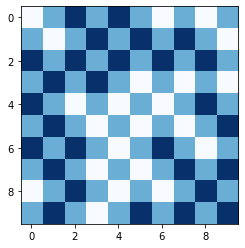

In [284]:
%matplotlib inline

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure()
ims = []
for i in range(i2):
    if i%100 == 0:
        im = plt.imshow(np.array(runs['run(3, 0.01, 0)'].loc[i,:99]).reshape(lattice_size, lattice_size), cmap='Blues', animated=True)
        ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

writer = PillowWriter(fps=10)
ani.save("demo2.gif", writer=writer)

plt.show()

0.01
0.5
1
1.5
2.0
2.5
5


Text(0, 0.5, 'hamiltonian energy')

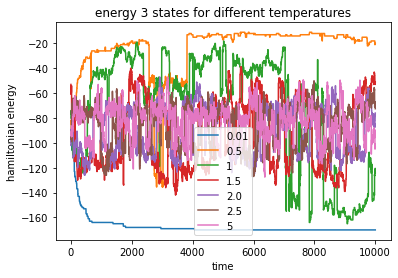

In [55]:
for temp in temperatures:
    print(f'{temp}')
    plt.plot(np.arange(0, i2+1, 1), runs[f'run(3, {temp}, 2)'][101], label=temp)

plt.legend()
plt.title('energy 3 states for different temperatures')
plt.xlabel('time')
plt.ylabel('hamiltonian energy')

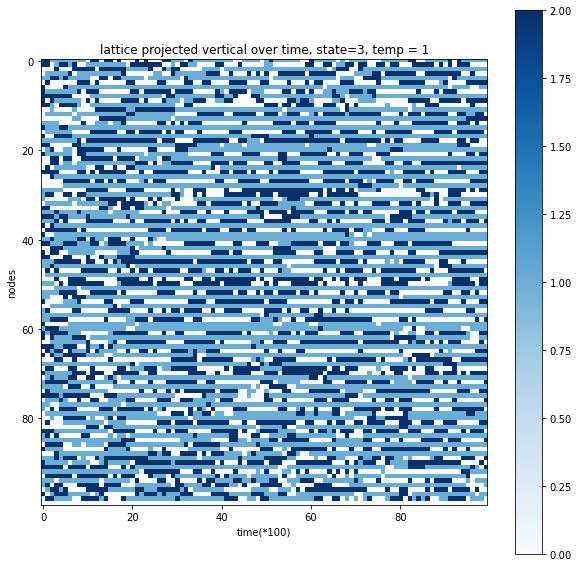

In [56]:
# np.array(runs['run(3, 0.01, 0)'].loc[:99])

plt.figure(figsize=(10,10))
plt.imshow(np.array(runs['run(3, 1, 0)'].iloc[::100, :100]).T, cmap='Blues')
plt.colorbar()
plt.title('lattice projected vertical over time, state=3, temp = 1')
plt.ylabel('nodes')
plt.xlabel('time(*100)')
plt.show()

### Autocorrelation

Text(0.5, 1.0, 'autocorr mean state all nodes, states = 3, T = 1')

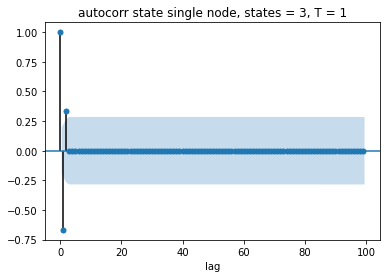

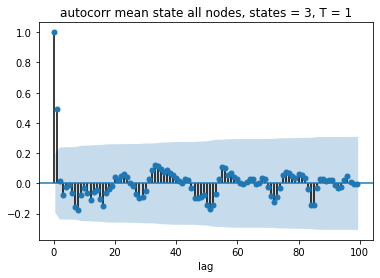

In [14]:
from statsmodels.graphics import tsaplots

v = np.array(runs['run(3, 0.01, 1)'].iloc[::100, :99])

mean = []
for ar in v:
    mean.append(np.mean(ar))
    
mean2 = runs[f'run(2, 1, 0)'][102]

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(v.T[22], lags=99)
plt.xlabel('lag')
plt.title('autocorr state single node, states = 3, T = 1')

fig2 = tsaplots.plot_acf(mean, lags=99)
plt.xlabel('lag')
plt.title('autocorr mean state all nodes, states = 3, T = 1')

# fig = tsaplots.plot_acf(v.T[21], lags=99)
# plt.xlabel('timesteps(*100)')
# plt.title('autocorr state single node,T=3')

# fig2 = tsaplots.plot_acf(mean, lags=99)
# plt.xlabel('timesteps(*100)')
# plt.title('autocorr mean state all nodes T=3')

### Number of Full Value Chains

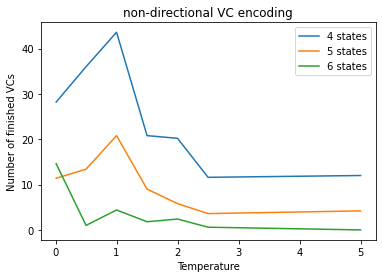

In [110]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [4,5,6]#[2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)

lattice_size = 10
timesteps = 100
i1 = lattice_size**2 + 1
i2 = lattice_size**2 * timesteps - 1

global_satisfactions = []
for state in states:
#     print(state)
    G_init, J, system_hamiltonian, A, fm = simulate(1, state)
    global_statisfactions = []
    for temp in temperatures:
        fh = 0
        sh = 0
        satisfaction = 0
        avg = []
        for run in samples:
            avg.append(check(np.array(runs[f'run{state,temp,run}'].iloc[-1, :100]), A, J)[-1])
        global_statisfactions.append(np.mean(avg))
#         print(global_statisfactions)
    plt.plot(temperatures, global_statisfactions, label=f'{state} states')
    
plt.ylabel('Number of finished VCs')
plt.xlabel('Temperature')
plt.title('non-directional VC encoding')
plt.legend()

### length of VC's

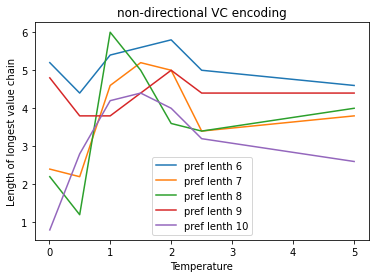

In [183]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [6, 7, 8, 9, 10] #[2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)

lattice_size = 10
timesteps = 100
i1 = lattice_size**2 + 1
i2 = lattice_size**2 * timesteps - 1

global_satisfactions = []
for state in states:
#     print(state)
    G_init, J, system_hamiltonian, A, fm = simulate(1, state)
    global_satisfactions = []
    for temp in temperatures:
        fh = 0
        sh = 0
        satisfaction = 0
        avg = []
        for run in samples:
            chain_satisfaction = check(np.array(runs[f'run{state,temp,run}'].iloc[-1, :100]), A, J)
            ls = [i for i, e in enumerate(chain_satisfaction) if e != 0]
            length = 0
            if ls != []:
                length = ls[-1] + 1
            avg.append(length)
            
        global_satisfactions.append(np.mean(avg))
    plt.plot(temperatures, global_satisfactions, label=f'pref lenth {state}')
    
plt.ylabel('Length of longest value chain')
plt.xlabel('Temperature')
plt.title('non-directional VC encoding')
plt.legend()

### local satisfaction

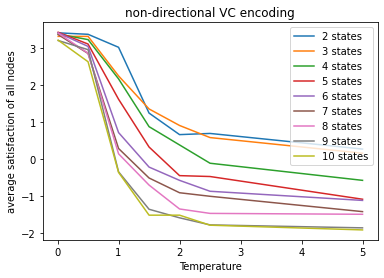

In [245]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)

lattice_size = 10
timesteps = 100
i1 = lattice_size**2 + 1
i2 = lattice_size**2 * timesteps - 1

global_satisfactions = []
for state in states:
    G_init, J, system_hamiltonian, A, fm = simulate(1, state)
    mean_local_satisfaction = []
    for temp in temperatures:
        fh = 0
        sh = 0
        satisfaction = 0
        avg = []
        for run in samples:
            arr = np.array(runs[f'run{state,temp,run}'].iloc[-1, :100])
            avg.append(check_local(arr, A, J))
#             print(avg)
        mean_local_satisfaction.append(np.mean(avg))
#             print(check_local(np.array(runs[f'run{state,temp,run}'].iloc[-1, :100]), A, J)) 
    plt.plot(temperatures, mean_local_satisfaction, label=f'{state} states')

plt.ylabel('average satisfaction of all nodes')
plt.xlabel('Temperature')
plt.title('non-directional VC encoding')
plt.legend()